In [70]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from IPython.display import clear_output

''' this is an adapted version of ricky's ode_demo.py '''


" this is an adapted version of ricky's ode_demo.py "

In [ ]:
from cosmoNODE.loaders import Anode as A
device = torch.device('cpu')

In [ ]:
from cosmoNODE.loaders import LC

In [93]:
adjoint = False

viz = True
viz_at_end = True
data_size = 350
batch_time = 25
batch_size = 175

test_freq = 5

In [3]:
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [4]:
a = A()
dataloader = DataLoader(a)
item = a[0]
lc = item[0]
obj_class = item[1]
lc = lc.squeeze()

In [30]:
mjds = lc[:, 0]
fluxes = lc[:, 1]
flux_y0 = fluxes[0].reshape(1, -1) # torch.Size([1, 1])
true_f = fluxes.reshape(-1, 1, 1)

tensor([[-544.8103]])
tensor([[[ -544.8103]],

        [[ -816.4343]],

        [[ -471.3855]],

        [[ -388.9850]],

        [[ -681.8589]],

        [[-1061.4570]],

        [[ -524.9546]],

        [[ -393.4802]],

        [[ -355.8868]],

        [[ -548.0135]],

        [[ -815.1886]],

        [[ -475.5161]],

        [[ -405.6638]],

        [[ -421.1991]],

        [[ -554.9032]],

        [[ -820.0428]],

        [[ -477.0047]],

        [[ -400.2704]],

        [[ -415.2869]],

        [[ -630.5237]],

        [[ -921.0025]],

        [[ -518.5340]],

        [[ -422.1845]],

        [[ -422.8151]],

        [[ -280.0395]],

        [[ -449.0956]],

        [[ -316.7049]],

        [[ -332.8854]],

        [[ -365.0758]],

        [[  391.3992]],

        [[   35.5118]],

        [[  330.6239]],

        [[  360.3979]],

        [[  369.4397]],

        [[  168.7399]],

        [[  129.5419]],

        [[   30.1207]],

        [[  -60.9423]],

        [[ -128.9203]],

   

In [6]:
true_y0 = torch.tensor([[2., 0.]]) # torch.Size([1, 2])
t = torch.linspace(0., 25., data_size)
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]])

In [94]:
def flux_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_f[s]  # (M, D)
    batch_t = mjds[:batch_time]  # (T)
    batch_y = torch.stack([true_f[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y

In [95]:
batch_1 = flux_batch()
batch_2 = flux_batch()

In [96]:
by0_f, bt_f, by_f = flux_batch()
print(f'by0_f.shape : {by0_f.shape}, bt_f.shape: {bt_f.shape}, by_f.shape: {by_f.shape}')

by0_f.shape : torch.Size([175, 1, 1]), bt_f.shape: torch.Size([25]), by_f.shape: torch.Size([25, 175, 1, 1])


In [9]:
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 1),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

In [10]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y

In [11]:
by0_f, bt_f, by_f = flux_batch()
# by0, bt, by = get_batch()

In [12]:
# print(f'by0.shape : {by0.shape}, bt.shape: {bt.shape}, by.shape: {by.shape}')
print(f'by0.shape : {by0_f.shape}, bt.shape: {bt_f.shape}, by.shape: {by_f.shape}')

by0.shape : torch.Size([50, 1, 1]), bt.shape: torch.Size([25]), by.shape: torch.Size([25, 50, 1, 1])


In [13]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 1),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

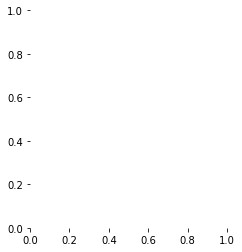

In [15]:
fig = plt.figure(figsize=(12, 4), facecolor='white')
ax_traj = fig.add_subplot(131, frameon=False)
# ax_phase = fig.add_subplot(132, frameon=False)
# ax_vecfield = fig.add_subplot(133, frameon=False)
plt.show(block=False)

In [16]:
def visualize(true_y, pred_y, odefunc, itr):
    ax_traj.cla()
    ax_traj.set_title('Trajectories')
    ax_traj.set_xlabel('mjd')
    ax_traj.set_ylabel('flux')
    ax_traj.plot(mjds.numpy(), true_y.numpy()[:, 0, 0])
    ax_traj.plot(mjds.numpy(), pred_y.numpy()[:, 0, 0], '--')
    ax_traj.set_xlim(mjds.min(), mjds.max())
#     ax_traj.set_ylim(-2, 2)
    ax_traj.legend()

#     ax_phase.cla()
#     ax_phase.set_title('Phase Portrait')
#     ax_phase.set_xlabel('x')
#     ax_phase.set_ylabel('y')
#     ax_phase.plot(true_y.numpy()[:, 0], true_y.numpy()[:, 1], 'g-')
#     ax_phase.plot(pred_y.numpy()[:, 0], pred_y.numpy()[:, 1], 'b--')
#     ax_phase.set_xlim(0, )
#     ax_phase.set_ylim(-2, 2)

#     ax_vecfield.cla()
#     ax_vecfield.set_title('Learned Vector Field')
#     ax_vecfield.set_xlabel('x')
#     ax_vecfield.set_ylabel('mjd')

#     y, x = np.mgrid[-2:2:21j, -2:2:21j]
#     dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2))).cpu().detach().numpy()
#     mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
#     dydt = (dydt / mag)
#     dydt = dydt.reshape(21, 21, 2)

#     ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
#     ax_vecfield.set_xlim(-2, 2)
#     ax_vecfield.set_ylim(-2, 2)

    fig.tight_layout()
#     plt.savefig('png/{:03d}'.format(itr))
    plt.show()
    plt.pause(0.001)


In [89]:
epochs = 5
niters = 100
odefunc = ODEFunc()
optimizer = optim.RMSprop(odefunc.parameters(), lr=1e-1)
ii = 0
losses = []
# itr = 1

In [ ]:
for epoch in range(1, epochs+1):    
    for itr in range(1, niters + 1):
        optimizer.zero_grad()
        by0_f, bt_f, by_f = flux_batch()
        pred_f = odeint(odefunc, by0_f, bt_f, rtol=10, atol=5)
        loss = torch.mean(torch.abs(pred_f - by_f))
        loss.backward()
        optimizer.step()
#         print(itr)
        if itr % test_freq == 0:
            with torch.no_grad():
                clear_output()
                pred_f = odeint(odefunc, flux_y0, mjds, rtol=10, atol=5)
                loss = torch.mean(torch.abs(pred_f - true_f))
                losses.append(loss)
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                plt.plot(mjds.tolist(), pred_f.flatten().tolist())
                plt.show()
                ii += 1    

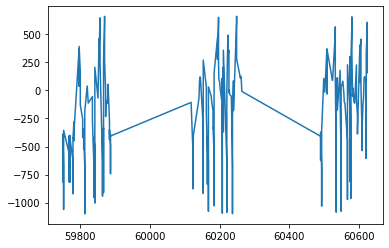

In [90]:
# print(losses)

# pred_f = odeint(odefunc, flux_y0, mjds)
# visualize(true_f, pred_f.detach(), odefunc, itr)

# without batching
# true_f all of the fluxes

mjds.shape
flat_f = true_f.flatten()
plt.plot(mjds.tolist(), flat_f.tolist())

In [88]:
# true_f.numpy()[:, 0, 1]
pred_f.detach().numpy()[:, 0, 0]
# , t.numpy(), true_y.numpy()[:, 0, 1]

array([[-113.58843 ],
       [-113.55888 ],
       [-113.52935 ],
       [-113.49985 ],
       [-105.703514],
       [-105.672455],
       [-105.64139 ],
       [-105.594795],
       [-105.5482  ],
       [ -47.674652]], dtype=float32)

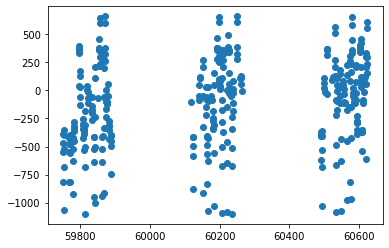

In [55]:
lc = LC() # light curve but treating different passbands as distinct lightcurves
lc[0]
